In [1]:
#import the files 
import re 
import nltk
import ssl
import pandas as pd 
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
import scipy.stats as ss
import seaborn as sns 

/Users/edmond/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
stop_words = list(set(stopwords.words('english')))
# JJ/R/S = adjective/comparitive/superlative
allowed_word_types = ["JJ","JJR","JJS"]
#open the data 
test_data = pd.read_csv('testing_set.csv')
train_data = pd.read_csv('training_set.csv')

In [3]:
#input tokenized list of words from review 
#return tokenized list without stop words 
def remove_stopword(data_input):
    cleaned_words = []
    for word in data_input: 
        if word not in stop_words: 
            cleaned_words.append(word)
    return (cleaned_words)

# input tokenized and pos tagged list 
# return list of just adjectives
def only_adjectives(data_input):
    cleaned_words = []
    for word, pos in data_input: 
        if pos in allowed_word_types:
            cleaned_words.append(word)
    return (cleaned_words)

In [4]:
#clean the training set for everything except for adjectives 
corpus = []

#lower case 
train_data["Review"] = train_data["Review"].apply(lambda x:x.lower())
#get rid of punctuation
train_data["Review"] = train_data["Review"].apply(lambda x:re.sub('[^a-zA-Z]',' ',x))
#split
train_data["Review"] = train_data["Review"].apply(lambda x:x.split())
#remove the stop words 
train_data["Review"] = train_data["Review"].apply(lambda x: remove_stopword(x))

#pos tag --> creates tuple (word,pos-tag)
train_data["Review"] = train_data["Review"] = train_data["Review"].apply(lambda x:nltk.pos_tag(x))
#Select only adjectives and remove pos-tags
train_data["Review"] = train_data["Review"].apply(lambda x:only_adjectives(x))


In [5]:

#create list of all adjectives from reviews in train_data
all_review_train = []
for row in train_data["Review"]:
    for word in row:
        all_review_train.append(word)

In [6]:
# BoW using count vectorizer 
cv = CountVectorizer()
cv.fit(all_review_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [8]:
train_data_2 = pd.read_csv('training_set.csv')

#do fit_transform override the previous 
X_train = cv.transform(train_data_2["Review"]).toarray()
y_train = train_data_2["Liked"].values

#train the model 
classifier = BernoulliNB(alpha=0.8)
classifier.fit(X_train, y_train)

# import the testing dataset 
test_data = pd.read_csv('testing_set.csv')
#vectorize the testing data 
X_test = cv.transform(test_data["Review"]).toarray()
y_test = test_data["Liked"].values

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix:\n",cm)

# Accuracy, Precision and Recall
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
score1 = accuracy_score(y_test,y_pred)
score2 = precision_score(y_test,y_pred)
score3= recall_score(y_test,y_pred)
print("\n")
print("Accuracy is ",round(score1*100,2),"%")
print("Precision is ",round(score2,2))
print("Recall is ",round(score3,2))



Confusion Matrix:
 [[109  26]
 [ 60 105]]


Accuracy is  71.33 %
Precision is  0.8
Recall is  0.64


In [9]:
#import the resturant data and reviews 
business = pd.read_csv("cleaned_business.csv")
reviews = pd.read_csv("cleanish_reviews.csv") 
ids = pd.read_csv('list_buiss_id.txt', sep=" ", header=None)
ids.columns = ["id"]

In [12]:
columns = ["business_id", "business_name", "our_score", "stars"]
final_results = pd.DataFrame(columns=columns)
for i in range(len(ids)): 
    id_curr = ids.iloc[i].id
    
    
    #Review data that matches the current business id 
    all_reviews = reviews[reviews["business_id"] == id_curr]
    
    #vectorize the reviews for that resturant 
    X_test = cv.transform(all_reviews["text"]).toarray()
    #creates the predicted sentiment for each review 
    y_pred = classifier.predict(X_test)
    #you dont have to round 
    y_pred = np.mean(y_pred)*100
    #get the row in dataframe of current buis 
    curr_buis = business.loc[business['business_id'] == id_curr]
    #modify the star ratings to the same scale 
    curr_star = (curr_buis["stars"].values[0]/5)*100
    #update the final dataframe with all the info 
    
    final_results = final_results.append({"business_id":id_curr, "business_name":curr_buis["name"].values[0],"our_score":y_pred, "stars":curr_star}, ignore_index = True)

In [13]:
# Find the correlation
ss.pearsonr(final_results["our_score"], final_results["stars"])

(0.8030835169169852, 9.17691372936888e-24)

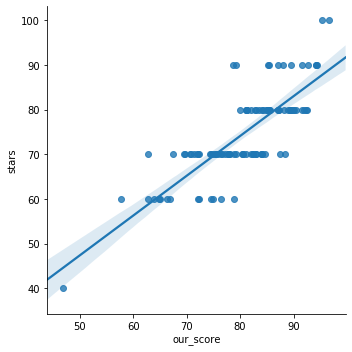

In [14]:
#visualize the correlation so we can insert into the paper 
g = sns.lmplot(x="our_score", y="stars", data=final_results)

In [15]:
final_results.filter(items=["our_score",'stars']).corr()

,our_score,stars
our_score,1.000000,0.803084
stars,0.803084,1.000000
